In [76]:
import wikipedia as wp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.cm import ScalarMappable

## Part 1:

Retrieving information from Wikipedia on the average temperature in Italy. We will use that to plot it against the number of new cases to visually demonstrate a correlation between the number of new cases and temperature.

In [77]:
# Wikipedia scrapper

wiki_page = 'Climate_of_Italy'
html = wp.page(wiki_page).html().replace(u'\u2212', '-').replace('(°F)', '')

def dataframe_cleaning(table_number: int):
    global html
    df = pd.read_html(html, encoding='utf-8')[table_number]
    df.drop(np.arange(5, len(df.index)), inplace=True)
    df.columns = df.columns.droplevel()
    df.drop('Year', axis=1, inplace=True)
    
    find = '\((.*?)\)'
    for i, column in enumerate(df.columns):
        if i>0:
            df[column] = (df[column]
                          .str.findall(find)
                          .map(lambda x: (float(x[0])-32)* (5/9)))
    return df

# Setting up all the DataFrames that will be used to plot Italy's average temrpeature with high and low variation. 

potenza_df = dataframe_cleaning(3)
milan_df = dataframe_cleaning(4)
florence_df = dataframe_cleaning(6)

# Constructing aggregated DataFrame for all temperatures in Italy:

concat_df = pd.concat((potenza_df, milan_df, florence_df))

italy_df = pd.DataFrame()
for i, index in enumerate(list(set(concat_df['Month']))):
    if i == 0:
        temp_df = concat_df[concat_df['Month'] == index]
        temp_df = temp_df.groupby('Month').agg(np.max)
    if i in range(1, 4):
        temp_df = concat_df[concat_df['Month'] == index]
        temp_df = temp_df.groupby('Month').agg(np.mean)
    if i == 4:
        temp_df = concat_df[concat_df['Month'] == index]
        temp_df = temp_df.groupby('Month').agg(np.min)
    italy_df = italy_df.append(temp_df)

italy_df = italy_df.apply(lambda x: np.round(x, 2))
italy_df

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Month,,,,,,,,,,,,
Daily mean °C,5.72,7.50,10.28,13.00,17.72,21.39,24.61,24.61,20.50,15.50,9.89,6.78
Average low °C,0.57,1.30,3.72,6.43,10.81,14.37,17.04,17.02,13.70,9.33,4.52,1.67
Record low °C,-15.94,-11.83,-7.72,-2.78,1.11,5.07,8.87,8.13,2.61,-1.63,-6.48,-10.00
Average high °C,7.63,9.57,13.24,16.22,21.37,25.41,28.78,28.59,24.28,18.39,12.15,8.46
Record high °C,20.00,21.78,23.61,25.61,29.78,33.00,36.78,36.78,33.00,28.22,21.78,20.00


## Part 2: 

Retrieve .csv file with the information of number cases in Italy, incremental increase. Break the .csv into two DataFrames that can be plotted.  

In [78]:
url = 'Daily_Covis19_Italian_Data_Province_Incremental.csv'
covid_data = pd.read_csv(url, error_bad_lines=False)

# Grouping
covid_positive = covid_data.groupby('Date').agg({'Total Positive': np.sum})
covid_positive
covid_positive_2020 = covid_positive.loc['2020-02-24': '2020-12-31']
covid_positive_2021 = covid_positive.loc['2021-01-01': '2021-03-22']
covid_positive_2020

,Total Positive
Date,
2020-02-24,0
2020-02-25,322
2020-02-26,78
2020-02-27,250
2020-02-28,238
...,...
2020-12-27,8913
2020-12-28,8581
2020-12-29,11210


## Part 3: 

Construct a 1x3 plot to showcase the results of the findings.

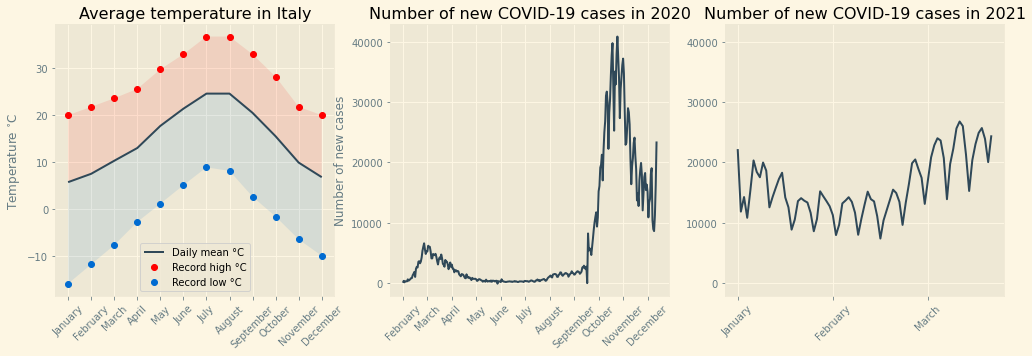

In [79]:
# All recovered data
plt.style.use('Solarize_Light2')
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[17, 5])
weather_legend = italy_df.index.tolist()


# ax1, plotting the average temperature in Italy
ax1.title.set_text('Average temperature in Italy')
ax1.scatter(italy_df.columns, italy_df.loc['Record high °C'], label = 'Record high °C', color = '#FF0000') 
ax1.scatter(italy_df.columns, italy_df.loc['Record low °C'], label = 'Record low °C', color = '#006BD1')
ax1.plot(italy_df.columns, italy_df.loc['Daily mean °C'], label = 'Daily mean °C', color='#2F4858')
ax1.set_ylabel('Temperature $^{\circ}$C')
ax1.legend()

# Setting red fill between max and min scatter
ax1.fill_between(range(len(italy_df.T.index)),
                 italy_df.loc['Record high °C'], italy_df.loc['Daily mean °C'],
                 facecolor='#FF0000', alpha=0.1, interpolate=False)

# Setting blue fill between min scatter and the min scatter
ax1.fill_between(range(len(italy_df.T.index)),
                 italy_df.loc['Daily mean °C'], italy_df.loc['Record low °C'],
                 facecolor='#006BD1', alpha=0.1, interpolate=False)
# Setting xlabels
plt.sca(ax1)
locations = np.arange(0, 12)
labels = pd.date_range('2020-01-01', '2020-12-31', freq='MS').month_name()
plt.xticks(locations, labels, rotation=45)


# ax2, plotting number of new COVID-19 cases in 2020
ax2.plot(covid_positive_2020, color='#2F4858')
ax2.title.set_text('Number of new COVID-19 cases in 2020')
ax2.set_ylabel('Number of new cases')

# Setting x-tick labels.
plt.sca(ax2)
locations = np.arange(0, 305, 30)
labels = pd.date_range('2020-02-01', covid_positive_2020.index.max(), freq='MS').month_name()
plt.xticks(locations, labels, rotation=45)


# ax2, plotting number of new COVID-19 cases in 2021
ax3 = plt.subplot(133, sharey = ax2)
ax3.plot(covid_positive_2021, color='#2F4858')
ax3.title.set_text('Number of new COVID-19 cases in 2021')
# ax3.set_ylabel('Number of new cases')

# Setting x-tick labels.
plt.sca(ax3)
min_date = pd.to_datetime(covid_positive_2021.index.min())
max_date = pd.to_datetime(covid_positive_2021.index.max())
locations = np.arange(0, len(pd.date_range(min_date, max_date)), 30)
labels = pd.date_range(min_date, max_date, freq='MS').month_name()
plt.xticks(locations, labels, rotation=45)


plt.show()

## Part 4: 

Summarize the findings in a single plot.

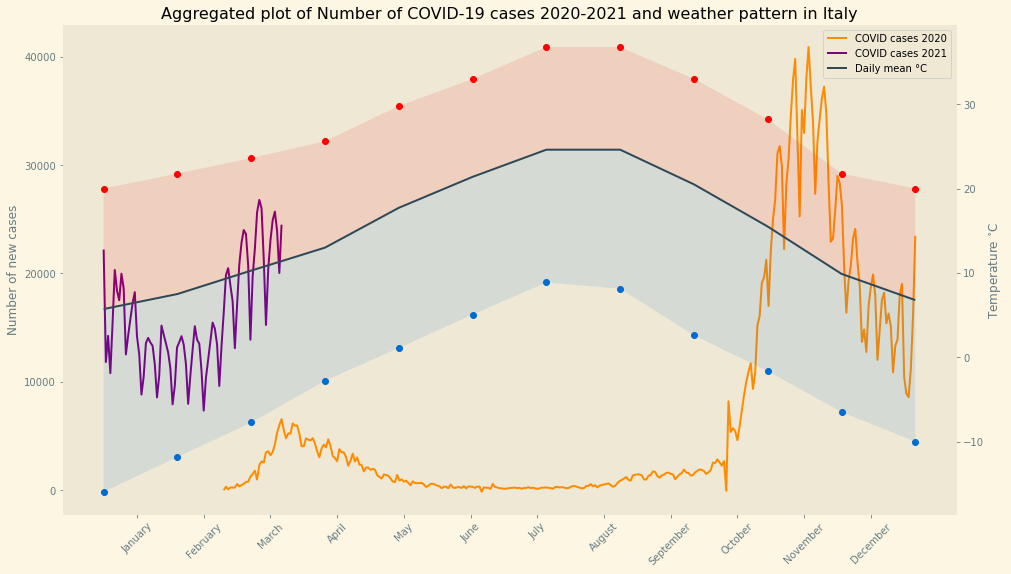

In [137]:
# Creating plot
fig, ax = plt.subplots(figsize=[16, 9])
plt.title('Aggregated plot of Number of COVID-19 cases 2020-2021 and weather pattern in Italy')

ticks = np.arange(0, 366)
plt.xticks(ticks)

x = pd.to_datetime(covid_positive_2020.index.min()) 
y = pd.date_range('01/01/2020', x)

ln1 = ax.plot(np.arange(len(y)-1, 366), covid_positive_2020, label='COVID cases 2020', color='darkorange')
ln2 = ax.plot(covid_positive_2021, label='COVID cases 2021', color='purple')

ax.set_ylabel('Number of new cases')

locations = np.arange(15, 366-15, 30)
labels = pd.date_range('2020-01-01', '2020-12-31', freq='MS').month_name()
plt.xticks(locations, labels, rotation=45)


ax2 = ax.twiny().twinx()

ax2.scatter(italy_df.columns, italy_df.loc['Record high °C'], label = 'Record high °C', color = '#FF0000') 
ax2.scatter(italy_df.columns, italy_df.loc['Record low °C'], label = 'Record low °C', color = '#006BD1')
ln3 = ax2.plot(italy_df.columns, italy_df.loc['Daily mean °C'], label = 'Daily mean °C', color='#2F4858')
ax2.set_ylabel('Temperature $^{\circ}$C')

# Setting red fill between max and min scatter
ax2.fill_between(range(len(italy_df.T.index)),
                 italy_df.loc['Record high °C'], italy_df.loc['Daily mean °C'],
                 facecolor='#FF0000', alpha=0.1, interpolate=False)

# Setting blue fill between min scatter and the min scatter
ax2.fill_between(range(len(italy_df.T.index)),
                 italy_df.loc['Daily mean °C'], italy_df.loc['Record low °C'],
                 facecolor='#006BD1', alpha=0.1, interpolate=False)
plt.xticks([])


lns = ln1 + ln2 + ln3
legends = [l.get_label() for l in lns]
ax2.legend(lns, legends, loc=0)

plt.rcParams["axes.grid"] = False

plt.show()